In [1]:
import pandas as pd
import numpy  as np
import matplotlib.pyplot   as plt
import matplotlib.gridspec as gridspec

from scipy import optimize

In [2]:
# Plotting style
default_cmap = "viridis"
figure_size  = 10, 5
font_size    = 16

plt.rcParams["figure.figsize"] =   figure_size
plt.rcParams[  "font.size"   ] =   font_size
plt.rcParams[  "image.cmap"   ] =   default_cmap

plt.style.use(plt.style.available[10])

#set number of bins
nbins = 100

# 1. Import data

In [3]:
region = 'Csphotopeak'
df = pd.HDFStore('pmaps_corrected_{}_6206.h5'.format(region))['']

# 2. Corrected energy spectra overview

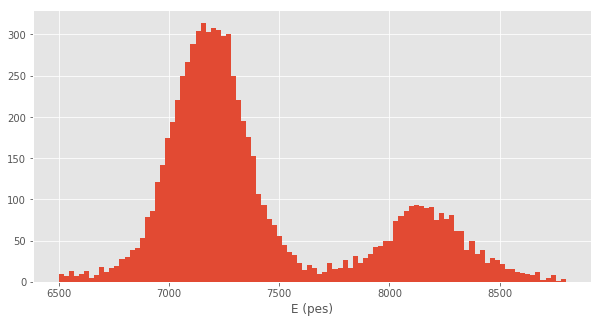

In [4]:
Emax = 8.8e3
Emin = 6.5e3

df['e'].hist(bins=nbins, range = (Emin, Emax));
plt.xlabel('E (pes)', fontsize=12);

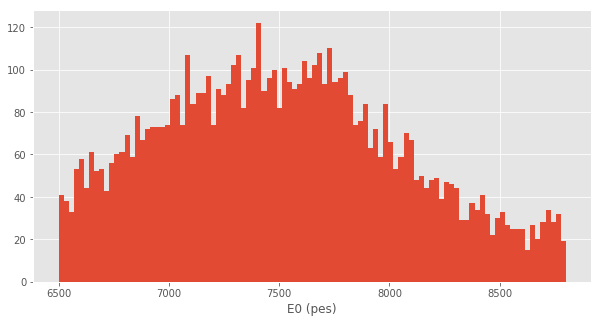

In [5]:
df['e0'].hist(bins=nbins, range = (Emin, Emax));
plt.xlabel('E0 (pes)', fontsize=12);

/home/gonzalo/anaconda3/envs/IC-3.6-2018-08-29/lib/python3.6/site-packages/numpy/lib/histograms.py:720: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/gonzalo/anaconda3/envs/IC-3.6-2018-08-29/lib/python3.6/site-packages/numpy/lib/histograms.py:721: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


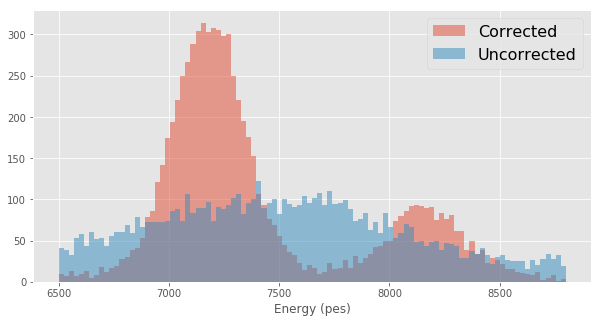

In [6]:
plt.hist(df['e'] , bins = nbins, range=(Emin, Emax), alpha=.5, label='Corrected' );
plt.hist(df['e0'], bins = nbins, range=(Emin, Emax), alpha=.5, label='Uncorrected' );
plt.legend(fontsize = 16);
plt.xlabel('Energy (pes)', fontsize=12);

# 3. Select region

In [7]:
Emax = 8.8e3
Emin = 6.5e3

In [8]:
df = df[(df.e<Emax) & (df.e>Emin)]

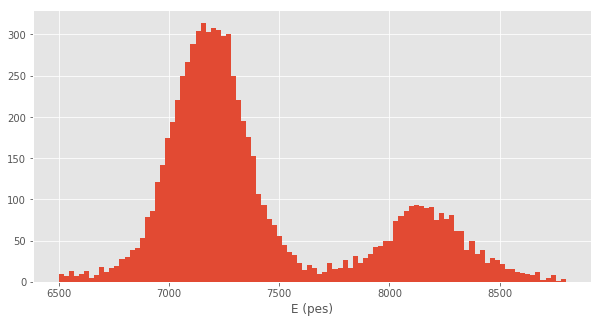

In [9]:
fig = plt.figure()
ax = fig.add_subplot(111)

ydata, xdata, __ = ax.hist(df['e'], bins=nbins, range = (Emin,Emax));
plt.xlabel('E (pes)', fontsize=12);

# 4. Fitting photopeak

We perform a gaussian fit for the photopeak.

$$F(E) = A e^{-(E-E_{ph})^2/2\sigma^2}$$

In [10]:
def F(E, Eph, sig, A):
    return A * np.e**(-(E-Eph)**2/(2*sig**2))

def chisq(F, popt, xdata, ydata):
    return np.sum((F(xdata, *popt)-ydata)**2/((len(xdata)-len(popt))*ydata))

In [11]:
#XRay 1
Emax1 = 7.6e3
Emin1 = 6.5e3
df1 = df[(df.e<Emax1) & (df.e>Emin1)]

ydata1, xdata1 = np.histogram(df1['e'], bins=int(.5*nbins), range=(Emin1, Emax1))
xdata1 = np.array([(xdata1[i+1] + xdata1[i])/2 for i in range(0, len(xdata1)-1)])

guess1 = [np.mean(df1['e']), np.std(df1['e']), np.max(ydata1)]
popt1, pcov1 = optimize.curve_fit(F, xdata1, ydata1, p0 = guess1, sigma = np.sqrt(ydata1), 
                                 bounds =([-np.inf, 0, -np.inf], np.inf))

Eph1, sig1, A1 = popt1[0], popt1[1], popt1[2]

In [12]:
#XRay 2
Emax2 = 8.8e3
Emin2 = 7.7e3
df2 = df[(df.e<Emax2) & (df.e>Emin2)]
ydata2, xdata2 = np.histogram(df2['e'], bins=int(.5*nbins), range=(Emin2, Emax2))
xdata2 = np.array([(xdata2[i+1] + xdata2[i])/2 for i in range(0, len(xdata2)-1)])

guess2 = [np.mean(df2['e']), np.std(df2['e']), np.max(ydata2)]
popt2, pcov2 = optimize.curve_fit(F, xdata2, ydata2, p0 = guess2, sigma = np.sqrt(ydata2))

Eph2, sig2, A2 = popt2[0], popt2[1], popt2[2]

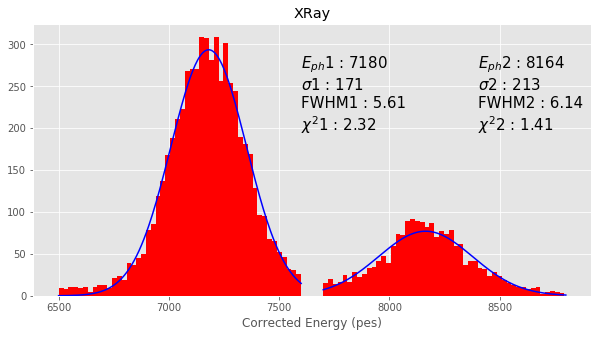

In [17]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.hist(df1['e'], bins=int(.5*nbins), color='r');
ax.hist(df2['e'], bins=int(.5*nbins), color='r');
#XRay 1
E1 = np.linspace(Emin1, Emax1, 2*nbins);
ax.plot(E1, F(E1, *popt1), color = 'b');

t = (r"$E_{{ph}}1$ : {}"     .format(int(Eph1)) + 
     "\n" + "$\sigma 1$ : {}" .format(int(sig1))  +
     "\n" + r"FWHM1 : {}"    .format(round(sig1 / Eph1 * 235, 2)) + 
     "\n" + r"$\chi^21$ : {}".format(round(chisq(F, popt1, xdata1, ydata1),2))) 

ax.text(7.6e3, 200, s = t, fontsize = 15);

#XRay 2
E2 = np.linspace(Emin2, Emax2, 2*nbins);
ax.plot(E2, F(E2, *popt2), color = 'b');

t = (r"$E_{{ph}}2$ : {}"     .format(int(Eph2)) + 
     "\n" + "$\sigma 2$ : {}" .format(int(sig2))  +
     "\n" + r"FWHM2 : {}"    .format(round(sig2 / Eph2 * 235, 2)) + 
     "\n" + r"$\chi^22$ : {}".format(round(chisq(F, popt2, xdata2, ydata2),2))) 

ax.text(8.4e3, 200, s = t, fontsize = 15);




ax.set_xlabel('Corrected Energy (pes)');
ax.set_title('XRay');

In [18]:
print('Extrapolated FWHM (1):',sig1/Eph1 * 235 * (29.7/2458)**.5)

Extrapolated FWHM (1): 0.6170267404794826


In [20]:
print('Extrapolated FWHM (2):', sig2/Eph2 * 235 * (34/2458)**.5)

Extrapolated FWHM (2): 0.722263228745606


# 5. Searching correlations

## 5.1. Corrected Energy correlations

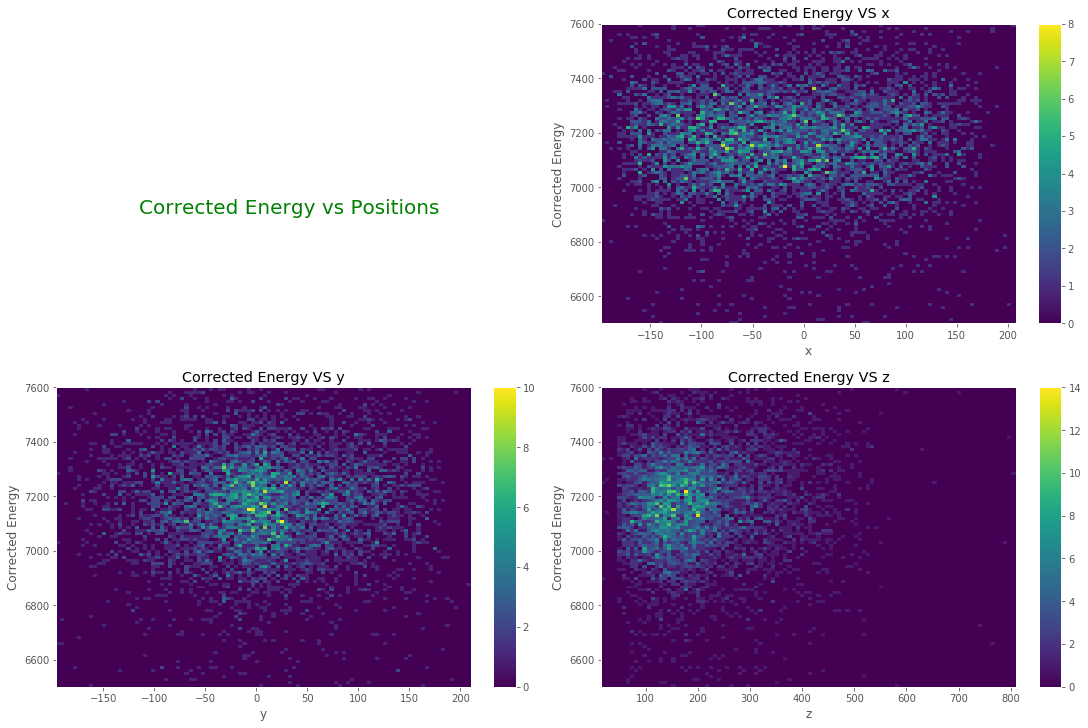

In [16]:
fig_ep = plt.figure(figsize =[15, 10] ,constrained_layout=True)

gs_ep = gridspec.GridSpec(2, 2, figure=fig_ep)

textpos = gs_ep[0, 0].get_position(fig_ep).get_points()
plt.figtext(textpos[0,0], (textpos[0,1] + textpos[1, 1])/2., 
            s='Corrected Energy vs Positions', figure=fig_ep, fontsize=20, color='green')

ax_ex = fig_ep.add_subplot(gs_ep[0, 1])
hist_ex = ax_ex.hist2d(df1['x'], df1['e'] , bins=nbins);
ax_ex.set_xlabel('x');
ax_ex.set_ylabel('Corrected Energy');
ax_ex.set_title('Corrected Energy VS x');
cbar_ex = fig_ep.colorbar(hist_ex[3], ax = ax_ex)

ax_ey = fig_ep.add_subplot(gs_ep[1, 0])
hist_ey = ax_ey.hist2d(df1['y'], df1['e'] , bins=nbins);
ax_ey.set_xlabel('y');
ax_ey.set_ylabel('Corrected Energy');
ax_ey.set_title('Corrected Energy VS y');
cbar_ey = fig_ep.colorbar(hist_ey[3], ax = ax_ey)

ax_ez = fig_ep.add_subplot(gs_ep[1, 1])
hist_ez = ax_ez.hist2d(df1['z'], df1['e'] , bins=nbins);
ax_ez.set_xlabel('z');
ax_ez.set_ylabel('Corrected Energy');
ax_ez.set_title('Corrected Energy VS z');
cbar_ez = fig_ep.colorbar(hist_ez[3], ax = ax_ez)

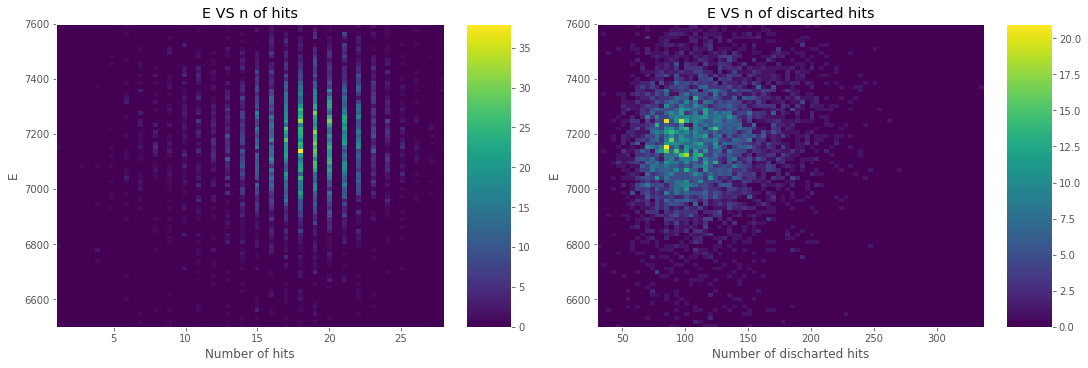

In [17]:
fig_e = plt.figure(figsize=[15, 5], constrained_layout=True)

gs_e = gridspec.GridSpec(1, 2, figure=fig_e)

ax_enhits = fig_e.add_subplot(gs_e[0])
hist_enhits = ax_enhits.hist2d(df1['nhits'], df1['e'] , bins=.8*nbins);
ax_enhits.set_xlabel('Number of hits');
ax_enhits.set_ylabel('E');
ax_enhits.set_title('E VS n of hits');
cbar_enhits = fig_e.colorbar(hist_enhits[3], ax = ax_enhits)

ax_enoqhits = fig_e.add_subplot(gs_e[1])
hist_enoqhits = ax_enoqhits.hist2d(df1['noqhits'], df1['e'] , bins=.8*nbins);
ax_enoqhits.set_xlabel('Number of discharted hits');
ax_enoqhits.set_ylabel('E');
ax_enoqhits.set_title('E VS n of discarted hits');
cbar_enoqhits = fig_e.colorbar(hist_enoqhits[3], ax = ax_enoqhits)

### 5.1.1. E vs Number of Slices

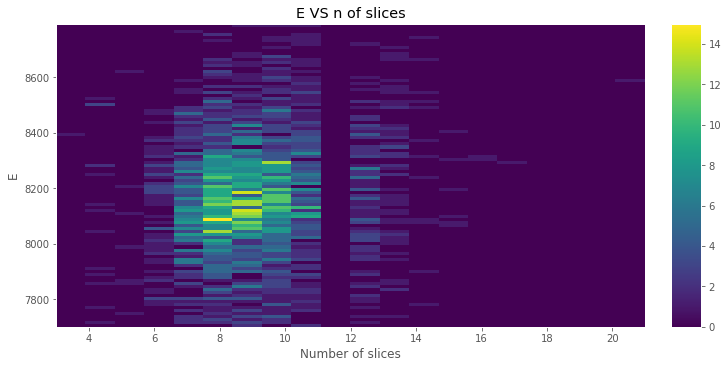

In [24]:
fig_enslices = plt.figure(constrained_layout=True)

gs_enslices = gridspec.GridSpec(1, 1, figure=fig_enslices)

ax_enslices = fig_enslices.add_subplot(gs_enslices[0, 0])
hist_enslices = ax_enslices.hist2d(df2['nslices'], df2['e'] , bins=[.2*nbins, nbins]);
ax_enslices.set_xlabel('Number of slices');
ax_enslices.set_ylabel('E');
ax_enslices.set_title('E VS n of slices');
cbar_enslices = fig_enslices.colorbar(hist_enslices[3], ax = ax_enslices)

## 5.2. Other Correlations

### 5.2.1 Number of slices

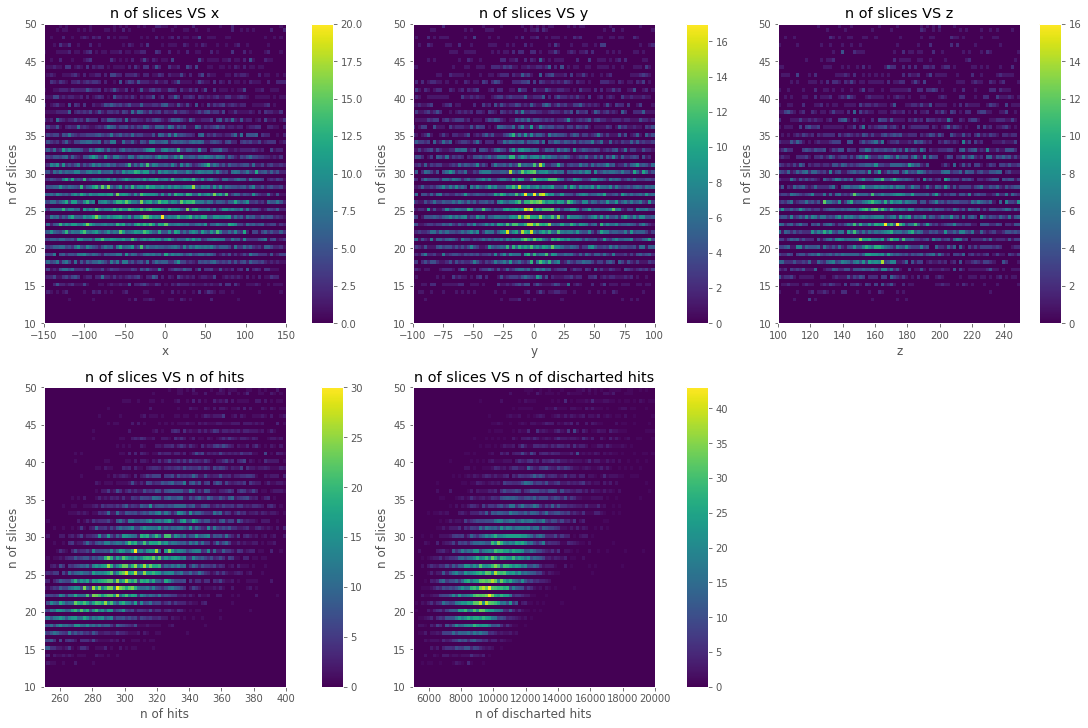

In [24]:
fig_nsl = plt.figure(figsize=[15, 10], constrained_layout=True)

gs_nsl = gridspec.GridSpec(2, 3, figure=fig_nsl)

ax_nslx = fig_nsl.add_subplot(gs_nsl[0,0])
hist_nslx = ax_nslx.hist2d(df['x'], df['nslices'] , bins=.8*nbins, range=((-150, 150),(10, 50)));
ax_nslx.set_xlabel('x');
ax_nslx.set_ylabel('n of slices');
ax_nslx.set_title('n of slices VS x');
cbar_nslx = fig_e.colorbar(hist_nslx[3], ax = ax_nslx)

ax_nsly = fig_nsl.add_subplot(gs_nsl[0,1])
hist_nsly = ax_nsly.hist2d(df['y'], df['nslices'] , bins=.8*nbins, range=((-100, 100),(10, 50)));
ax_nsly.set_xlabel('y');
ax_nsly.set_ylabel('n of slices');
ax_nsly.set_title('n of slices VS y');
cbar_nsly = fig_nsl.colorbar(hist_nsly[3], ax = ax_nsly)

ax_nslz = fig_nsl.add_subplot(gs_nsl[0,2])
hist_nslz= ax_nslz.hist2d(df['z'], df['nslices'] , bins=.8*nbins, range=((100, 250),(10, 50)));
ax_nslz.set_xlabel('z');
ax_nslz.set_ylabel('n of slices');
ax_nslz.set_title('n of slices VS z');
cbar_nslz = fig_nsl.colorbar(hist_nslz[3], ax = ax_nslz);

ax_nslnh = fig_nsl.add_subplot(gs_nsl[1,0])
hist_nslnh= ax_nslnh.hist2d(df['nhits'], df['nslices'] , bins=.8*nbins, range=((250, 400),(10, 50)));
ax_nslnh.set_xlabel('n of hits');
ax_nslnh.set_ylabel('n of slices');
ax_nslnh.set_title('n of slices VS n of hits');
cbar_nslnh= fig_nsl.colorbar(hist_nslnh[3], ax = ax_nslnh);

ax_nslnoh = fig_nsl.add_subplot(gs_nsl[1,1])
hist_nslnoh= ax_nslnoh.hist2d(df['noqhits'], df['nslices'] , bins=.8*nbins, range=((5e3, 20e3),(10, 50)));
ax_nslnoh.set_xlabel('n of discharted hits');
ax_nslnoh.set_ylabel('n of slices');
ax_nslnoh.set_title('n of slices VS n of discharted hits');
cbar_nslnoh= fig_nsl.colorbar(hist_nslnoh[3], ax = ax_nslnoh);

# 6. Other distributions

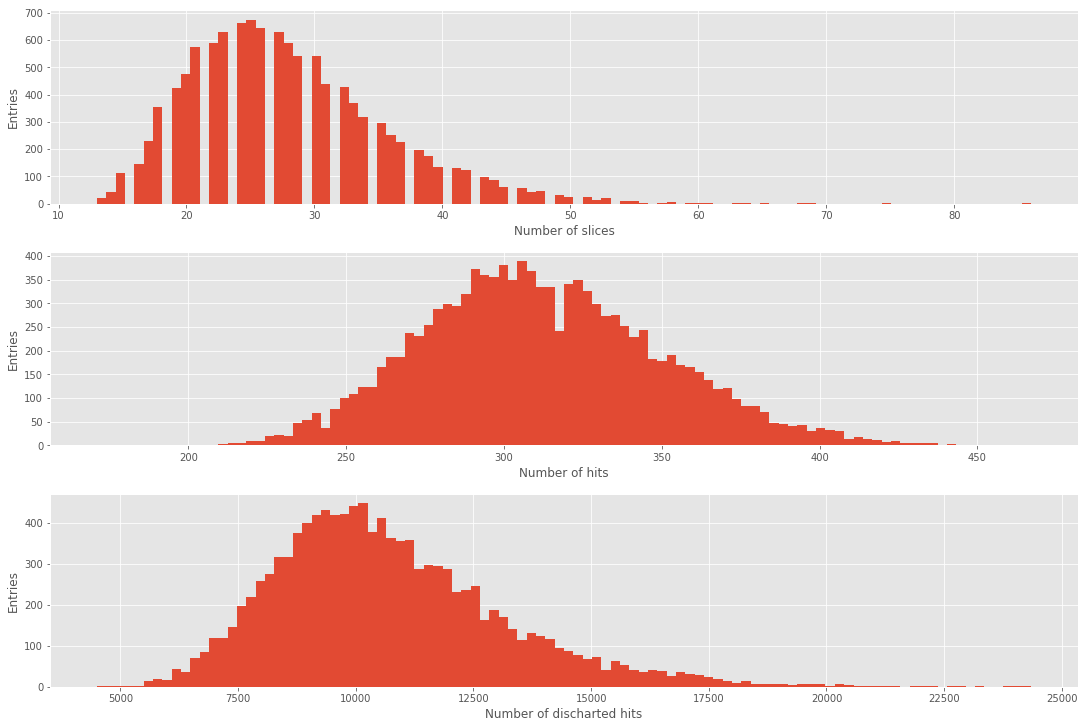

In [25]:
fig_d = plt.figure(figsize=[15, 10], constrained_layout=True)

gs_d = gridspec.GridSpec(3, 1, figure=fig_d)

ax_nsl = fig_d.add_subplot(gs_d[0]);
hist_nsl = ax_nsl.hist(df['nslices'] , bins=nbins);
ax_nsl.set_xlabel('Number of slices');
ax_nsl.set_ylabel('Entries');

ax_nh = fig_d.add_subplot(gs_d[1]);
hist_nh = ax_nh.hist(df['nhits'] , bins=nbins);
ax_nh.set_xlabel('Number of hits');
ax_nh.set_ylabel('Entries');

ax_noh = fig_d.add_subplot(gs_d[2]);
hist_noh = ax_noh.hist(df['noqhits'] , bins=nbins);
ax_noh.set_xlabel('Number of discharted hits');
ax_noh.set_ylabel('Entries');

# 7. Fiducial cuts

## 7.1. Fit

In [21]:
R_fid = 160
z_fid_max = 550
z_fid_min = 50

In [22]:
fid_df = df[(df.x0**2 + df.y0**2 < R_fid**2) & (df.z0 < z_fid_max) & (df.z0 > z_fid_min)]

In [23]:
#XRay 1
Emax1 = 7.6e3
Emin1 = 6.5e3
df1 = fid_df[(fid_df.e<Emax1) & (fid_df.e>Emin1)]

ydata1, xdata1 = np.histogram(df1['e'], bins=int(.5*nbins), range=(Emin1, Emax1))
xdata1 = np.array([(xdata1[i+1] + xdata1[i])/2 for i in range(0, len(xdata1)-1)])

guess1 = [np.mean(df1['e']), np.std(df1['e']), np.max(ydata1)]
popt1, pcov1 = optimize.curve_fit(F, xdata1, ydata1, p0 = guess1, sigma = np.sqrt(ydata1), 
                                 bounds =([-np.inf, 0, -np.inf], np.inf))

Eph1, sig1, A1 = popt1[0], popt1[1], popt1[2]

In [24]:
#XRay 2
Emax2 = 8.8e3
Emin2 = 7.7e3
df2 = fid_df[(fid_df.e<Emax2) & (fid_df.e>Emin2)]

ydata2, xdata2 = np.histogram(df2['e'], bins=int(.5*nbins), range=(Emin2, Emax2))
xdata2 = np.array([(xdata2[i+1] + xdata2[i])/2 for i in range(0, len(xdata2)-1)])

guess2 = [np.mean(df2['e']), np.std(df2['e']), np.max(ydata2)]
popt2, pcov2 = optimize.curve_fit(F, xdata2, ydata2, p0 = guess2, sigma = np.sqrt(ydata2))

Eph2, sig2, A2 = popt2[0], popt2[1], popt2[2]

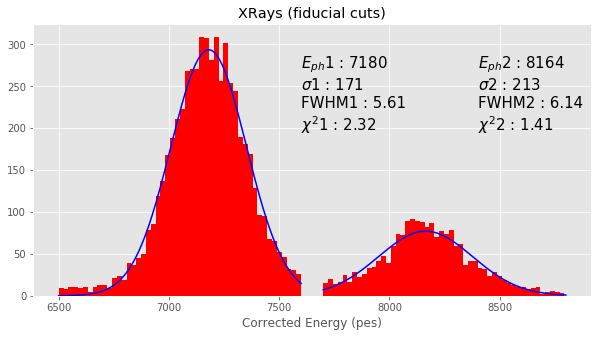

In [21]:
fig = plt.figure()
ax = fig.add_subplot(111)

ax.hist(df1['e'], bins=int(.5*nbins), color='r');
ax.hist(df2['e'], bins=int(.5*nbins), color='r');
#XRay 1
E1 = np.linspace(Emin1, Emax1, 2*nbins);
ax.plot(E1, F(E1, *popt1), color = 'b');

t = (r"$E_{{ph}}1$ : {}"     .format(int(Eph1)) + 
     "\n" + "$\sigma 1$ : {}" .format(int(sig1))  +
     "\n" + r"FWHM1 : {}"    .format(round(sig1 / Eph1 * 235, 2)) + 
     "\n" + r"$\chi^21$ : {}".format(round(chisq(F, popt1, xdata1, ydata1),2))) 

ax.text(7.6e3, 200, s = t, fontsize = 15);

#XRay 2
E2 = np.linspace(Emin2, Emax2, 2*nbins);
ax.plot(E2, F(E2, *popt2), color = 'b');

t = (r"$E_{{ph}}2$ : {}"     .format(int(Eph2)) + 
     "\n" + "$\sigma 2$ : {}" .format(int(sig2))  +
     "\n" + r"FWHM2 : {}"    .format(round(sig2 / Eph2 * 235, 2)) + 
     "\n" + r"$\chi^22$ : {}".format(round(chisq(F, popt2, xdata2, ydata2),2))) 

ax.text(8.4e3, 200, s = t, fontsize = 15);


ax.set_xlabel('Corrected Energy (pes)');
ax.set_title('XRays (fiducial cuts)');

In [22]:
print('Extrapolated FWHM (1):',sig1/Eph1 * 235 * (29.7/2458)**.5)

Extrapolated FWHM (1): 0.6170267404794826


In [23]:
print('Extrapolated FWHM (2):', sig2/Eph2 * 235 * (34/2458)**.5)

Extrapolated FWHM (2): 0.722263228745606
